<a href="https://colab.research.google.com/github/Jbridg12/Alzheimer_GAN/blob/main/AlzheimersGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
tf.config.run_functions_eagerly(True)

This is for setting up the dataset in google drive. May not need it any more but I'm not sure yet.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [ ]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


Image Processing

In [ ]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

In [ ]:
from zipfile import ZipFile
with ZipFile('alzheimer-mri-dataset.zip', 'r') as zipper:
  zipper.extractall()

In [ ]:
from os import listdir
from os.path import join, isdir
class_name = np.array([f for f in listdir('./Dataset') if isdir(join('./Dataset', f))])
n_classes = len(class_name)
print(n_classes)

4


In [ ]:
# From https://opensource.com/article/17/2/python-tricks-artists
from os import listdir
from PIL import Image

bad_files = []
for dir in listdir('Dataset/'):
  for file in listdir('Dataset/'+dir):
    # print(file)
    # break
    if file.endswith('.jpg'):
      try:
        img = Image.open('Dataset/'+dir+'/'+file)
        img.verify()
      except (IOError, SyntaxError) as e:
        print('Bad file:', file)
        path = 'Dataset/'+dir+'/'+file
        bad_files.append(path)

KeyboardInterrupt: ignored

In [ ]:
print(len(bad_files))
for file in bad_files:
  os.remove(file)

In [ ]:
# For replicable results
SEED = 0
# Size of Latent Input
noise_dim = 100
num_examples_to_generate = 16
# Size of the images is (128,128)
IMAGE_SIZE = (128, 128)
# Default batch size
BATCH_SIZE = 32
# Images are grayscale
COLOR_MODE = "grayscale"

# data_dir = "Dataset/"
data_dir=os.path.join('train_test/', 'train')

tf.random.set_seed(SEED)
np.random.seed(SEED)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/',
    validation_split=0.2,
    subset="training",
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


In [ ]:
def process(image,label):
    image = tf.cast(((tf.cast(image, tf.float32)/127.5) -1)  ,tf.float32)
    return image,label

train_data = train_data.map(process)

In [ ]:
for i, l in train_data:
  print(i.shape)
  break

Generate Examples

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.image.grayscale_to_rgb(images[i]).numpy().astype("uint8"))


Define Model Architectures

In [ ]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(noise_dim+1,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)

  model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 64, 64, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 64, 64, 16)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 128, 128, 16)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())


  model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 128, 128, 1)

  return model

In [ ]:
def discriminator_model():
  logitmodel = tf.keras.Sequential()

  logitmodel.add(layers.Conv2D(64,3,2,'same', input_shape=(128,128,1)))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(128,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(64,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(32,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Conv2D(8,3,2,'same'))
  logitmodel.add(layers.LeakyReLU())
  logitmodel.add(layers.Dropout(0.3))

  logitmodel.add(layers.Flatten())
  logitmodel.add(layers.Activation('sigmoid'))
  logitmodel.add(layers.Dense(1))
  
  return logitmodel

In [ ]:
generator = generator_model()
discriminator = discriminator_model()

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Define Loss and Optimizers

# New Section

In [ ]:
ent_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = ent_loss(tf.ones_like(real_output), real_output)
    fake_loss = ent_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return ent_loss(tf.ones_like(fake_output), fake_output)

In [ ]:
gen_lr = 0.0001
dis_lr = 0.0001

generator_optimizer = tf.keras.optimizers.Adam(gen_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(dis_lr)

# Training

In [ ]:
import sys
@tf.function
def train_step(image, label):

    # Add label to noise and images
    noise = tf.random.normal((label.shape[0], noise_dim)).numpy()
    l = label.numpy()
    noises = []
    for i in range(l.shape[0]):
      noises.append(np.append(noise[i], l[i]))
    
    n_and_l = tf.convert_to_tensor(np.array(noises))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(n_and_l, training=True)

      real_output = discriminator(image, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
def train(dataset, epochs):
  for (step, input_image) in train_data.repeat().take(EPOCHS).enumerate():
    start = time.time()

    train_step(input_image[0], input_image[1])      

    print ('Time for epoch {} is {} sec'.format(step + 1, time.time()-start))


In [ ]:
EPOCHS = 7000
train(train_data, EPOCHS)

Streaming output truncated to the last 5000 lines.
Time for epoch 2001 is 0.6945793628692627 sec
Time for epoch 2002 is 0.6898701190948486 sec
Time for epoch 2003 is 0.6839914321899414 sec
Time for epoch 2004 is 0.6946842670440674 sec
Time for epoch 2005 is 0.6943175792694092 sec
Time for epoch 2006 is 0.6977071762084961 sec
Time for epoch 2007 is 0.7005510330200195 sec
Time for epoch 2008 is 0.7064151763916016 sec
Time for epoch 2009 is 0.6878437995910645 sec
Time for epoch 2010 is 0.7045996189117432 sec
Time for epoch 2011 is 0.6997840404510498 sec
Time for epoch 2012 is 0.6948134899139404 sec
Time for epoch 2013 is 0.6927049160003662 sec
Time for epoch 2014 is 0.708977460861206 sec
Time for epoch 2015 is 0.6982555389404297 sec
Time for epoch 2016 is 0.6912195682525635 sec
Time for epoch 2017 is 0.6949305534362793 sec
Time for epoch 2018 is 0.6943387985229492 sec
Time for epoch 2019 is 0.6854257583618164 sec
Time for epoch 2020 is 0.6956777572631836 sec
Time for epoch 2021 is 0.69097

In [ ]:
num_labels = np.arange(0, n_classes).reshape(-1, 1)
print(num_labels.shape)

(4, 1)


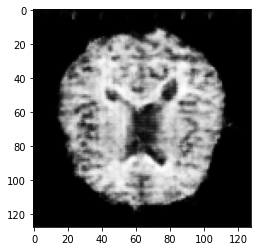

In [ ]:
import matplotlib.pyplot as plt
target_label = 3

test_noise = tf.random.normal([1, noise_dim]).numpy()
tst_in = []
tst_in.append(np.append(test_noise[0], target_label))
test_input = tf.convert_to_tensor(np.array(tst_in))
gen_img = generator(test_input, training=False)
plt.imshow(gen_img[0,:,:,0], cmap='gray')

In [ ]:
generator.save('saved_model/gen1')

INFO:tensorflow:Assets written to: saved_model/gen1/assets
